# Run Regularized Inversion Code
Run the `demreg` code of HK12 to find the emission measure distribution from the intensities. Save the derived emission measure distributions because this calculation takes a long time.

In [1]:
import os

import numpy as np
import pandas
from scipy.optimize import curve_fit
import scipy.linalg
import scipy.stats
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import LogFormatter
import seaborn as sns
import astropy.units as u
import astropy.constants as const
import hissw
from sunpy.map import Map,GenericMap
import h5py
from ChiantiPy.tools import filters as ch_filters

import synthesizAR
from synthesizAR.instruments import InstrumentHinodeEIS
from synthesizAR.util import EISCube,EMCube
from synthesizAR.atomic import EmissionModel

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


In [2]:
eis = InstrumentHinodeEIS([7.5e3,1.25e4]*u.s)

In [3]:
frequencies = [250,750,'750-ion',2500,5000]

In [12]:
temperature_bin_edges = 10.**(np.arange(5.6, 7.0, 0.05))*u.K

First, load the emission model.

In [4]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

List the resolved wavelengths for convenience.

In [5]:
resolved_wavelengths = np.sort(u.Quantity([rw for ion in emission_model.ions for rw in ion.resolved_wavelengths]))

and calculate the contribution functions.

In [6]:
pressure_const = 1e15*u.K*u.cm**(-3)
class FakeLoop(object):
    electron_temperature = np.logspace(5.5,7.5,100)*u.K
    density = pressure_const/electron_temperature
    
fake_loop = FakeLoop()
i_temperature,i_density = emission_model.interpolate_to_mesh_indices(fake_loop)

In [7]:
contribution_functions = {}
line_names = {}
for ion in emission_model.ions:
    for rw in ion.resolved_wavelengths:
        i_rw = np.where(ion.wavelength==rw)[0][0]
        emiss = map_coordinates(ion.emissivity[:,:,i_rw].value,
                                np.vstack([i_temperature,i_density]),order=3)*ion.emissivity.unit
        ioneq = splev(fake_loop.electron_temperature.value,
                      splrep(emission_model.temperature_mesh[:,0].value,
                             ion.fractional_ionization[:,0].value,k=1),ext=1)
        line_names[rw] = '{} {}'.format(ion.chianti_ion.meta['name'],rw.value)
        contribution_functions[rw] = (1./(np.pi*4.*u.steradian)*0.83
                                           *ioneq*ion.chianti_ion.abundance*emiss/fake_loop.density
                                           *(const.h.cgs*const.c.cgs)/rw.to(u.cm)/u.photon)

Now, load the time-average intensities and slice in wavelength and integrate at the desired indicies corresponding to the resolved wavelength. This gives us a map of integrated intensity for each of the lines that we are interested in.

In [54]:
line_intensities = {'{}'.format(freq):{} for freq in frequencies}

In [55]:
for freq in frequencies:
    for channel in eis.channels:
        tmp = EISCube('../data/eis_intensity_{}_tn{}_t7500-12500.h5'.format(channel['name'],freq))
        if type(freq) == int:
            tmp.data = (gaussian_filter(tmp.data.value,(channel['gaussian_width']['y'].value,
                                                        channel['gaussian_width']['x'].value,0.)))*tmp.data.unit
        for rw in resolved_wavelengths:
            i_center = np.where(np.isclose(tmp.wavelength.value,rw.value,atol=1.1e-2,rtol=0.))[0]
            if len(i_center) == 0:
                continue
            line_intensities['{}'.format(freq)][rw] = tmp[i_center-5:i_center+5].integrated_intensity

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/astropy/units/quantity.py:1023: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  out = super(Quantity, self).__getitem__(key)


Peek at the integrated intensities.

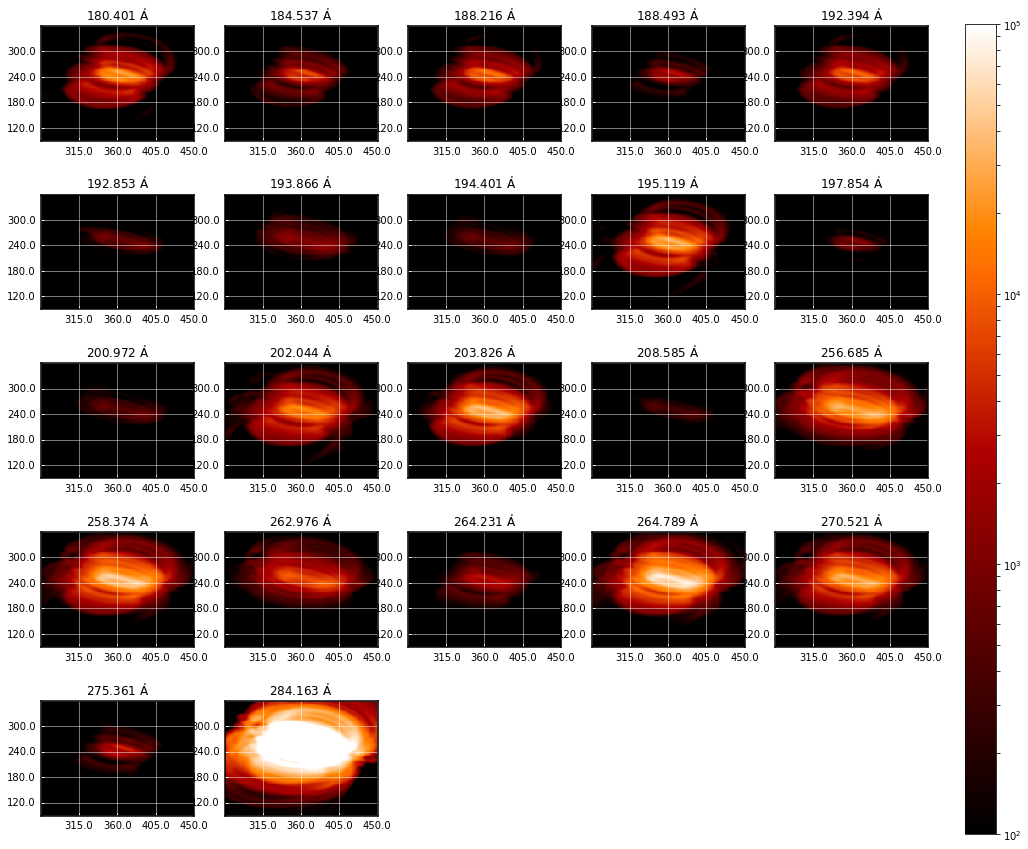

In [57]:
fig = plt.figure(figsize=(17,15))
plt.subplots_adjust(right=0.85)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
for i,rw in enumerate(resolved_wavelengths):
    tmp = (line_intensities['750'][rw]
           .submap(u.Quantity((270,450),u.arcsec),u.Quantity((90,360),u.arcsec))
          )
    ax = fig.add_subplot(5,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,annotate=False,title=False,
                  norm=matplotlib.colors.SymLogNorm(1,vmin=1e2,vmax=1e5)
                 )
    ax.set_title(r'{:.3f} {}'.format(rw.value,rw.unit.to_string(format='latex')))
cbar = fig.colorbar(im,cax=cax)

Reshape the data so that it can be passed to the demreg script.

In [58]:
k_matrix = []
intensity_matrix = []
line_names = []
for rw in resolved_wavelengths:
    line_name = '{}_{}'.format(rw.value,rw.unit)
    line_names.append(line_name)
    k_matrix.append(contribution_functions[rw].value.tolist())
    for freq in frequencies:
        line_intensities['{}'.format(freq)][rw].save('../data/eis_integrated_intensity_{}_{}.fits'.format(freq,line_name))

Now run the inversion code.

In [59]:
demreg_runner = hissw.ScriptMaker(extra_paths=['/home/wtb2/Documents/codes/demreg/idl/'],
                                  ssw_path_list=['vobs','ontology'])
static_input_vars = {
                     'log_temperature':np.log10(fake_loop.electron_temperature.value).tolist(),
                     'temperature_bins':temperature_bin_edges.value.tolist(),
                     'k_matrix':k_matrix,
                     'names':line_names,
                     'error_ratio':0.25,
                     'gloci':1,'reg_tweak':1,'timed':1
                    }
save_vars = ['dem','edem','elogt','chisq','dn_reg']

In [60]:
demreg_script = """
; load intensity from each channel/line
names = {{ names }}
eis_file_list = find_file('{{ fits_file_glob }}')
read_sdo,eis_file_list,ind,intensity
; load the contribution functions or response functions (called K in Hannah and Kontar 2012)
k_matrix = {{ k_matrix }}
; load temperature array over which K is computed
log_temperature = {{ log_temperature }}

; temperature bins
temperature_bins = {{ temperature_bins }}

; crude estimate of intensity errors
intensity_errors = intensity*{{ error_ratio }}

; inversion method parameters
reg_tweak={{ reg_tweak }}
timed={{ timed }}
gloci={{ gloci }}

; run the inversion method
dn2dem_pos_nb,intensity,intensity_errors,$
              k_matrix,log_temperature,temperature_bins,$
              dem,edem,elogt,chisq,dn_reg,$
              timed=timed,gloci=gloci,reg_tweak=reg_tweak
"""

In [61]:
for freq in frequencies:
    input_vars = static_input_vars.copy()
    input_vars['fits_file_glob'] = '/home/wtb2/Documents/projects/loops-workshop-2017-talk/data/eis_integrated_intensity_{}_*.fits'.format(freq)
    tmp = demreg_runner.run([(demreg_script,input_vars)],save_vars=save_vars,cleanup=True,verbose=True)
    tmp_cube = EMCube(np.swapaxes(tmp['dem'].T,0,1)*np.diff(temperature_bin_edges.value)*(u.cm**(-5)),
                      (line_intensities['{}'.format(freq)][resolved_wavelengths[0]].meta),temperature_bin_edges)
    tmp_cube.save('../data/em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq))

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ---------------------------------
| $SSW/vobs/gen/idl               |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl  

In [64]:
foo = EMCube.restore('../data/em_cubes_demreg_tn750_t7500-12500.h5')

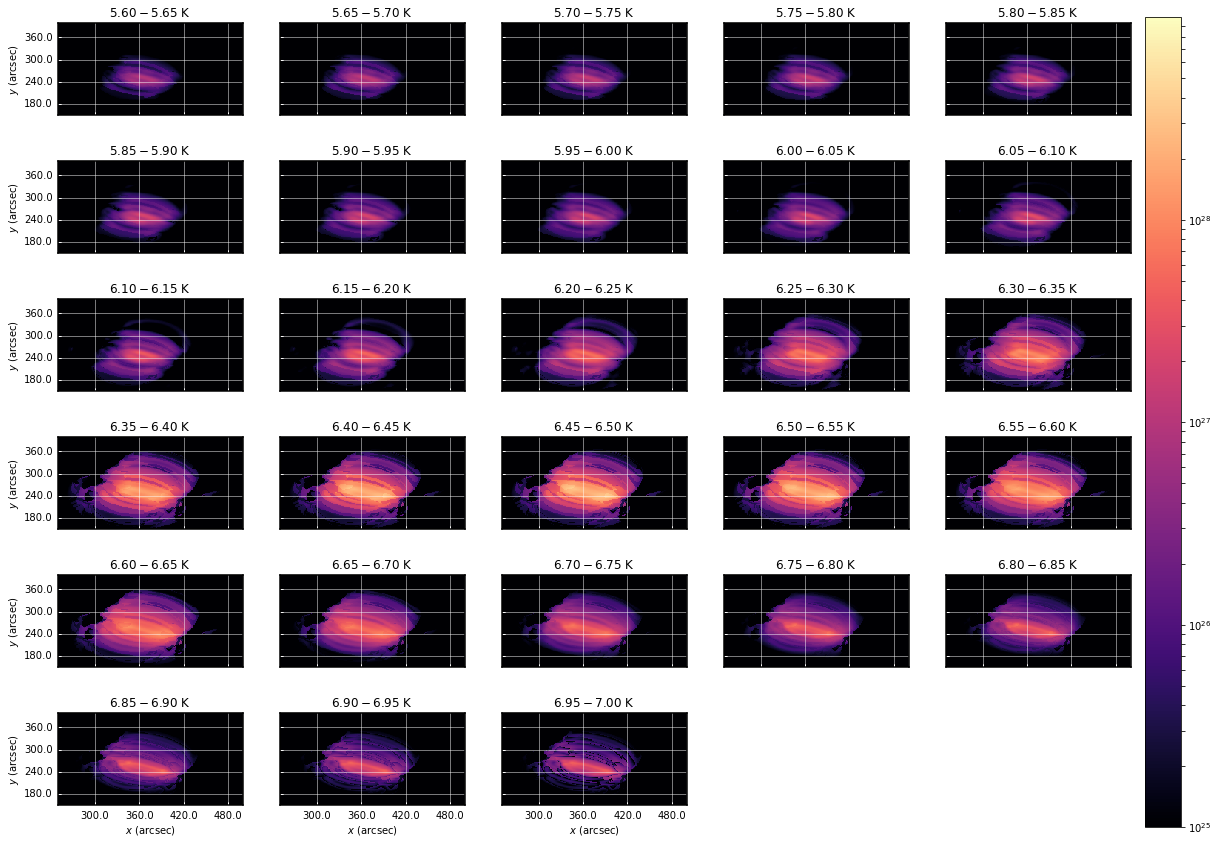

In [65]:
fig = plt.figure(figsize=(20,15))
plt.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.12, 0.025, 0.75])
plt.subplots_adjust(hspace=0.1)
for i in range(foo.temperature_bin_edges.shape[0]-1):
    # apply a filter to the 
    tmp = foo[i].submap(u.Quantity([250,500],u.arcsec),u.Quantity([150,400],u.arcsec))
    #tmp.data = gaussian_filter(tmp.data,
    #                           eis.channels[0]['gaussian_width']['x'].value
    #                          )
    # set up axes properly and add plot
    ax = fig.add_subplot(6,5,i+1,projection=tmp)
    im = tmp.plot(axes=ax,
                  annotate=False,
                  cmap=matplotlib.cm.get_cmap('magma'),
                  norm=matplotlib.colors.SymLogNorm(1, vmin=1e25, vmax=1e29)
                 )
    # set title and labels
    ax.set_title(r'${t0:.2f}-{t1:.2f}$ {uni}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                     t1=np.log10(tmp.meta['temp_b']),uni='K'))
    if i<25:
        ax.coords[0].set_ticklabel_visible(False)
    else:
        ax.set_xlabel(r'$x$ ({})'.format(u.Unit(tmp.meta['cunit1'])))
    if i%5==0:
        ax.set_ylabel(r'$y$ ({})'.format(u.Unit(tmp.meta['cunit2'])))
    else:
        ax.coords[1].set_ticklabel_visible(False)
cbar = fig.colorbar(im,cax=cax)